# Notebook Dedicado a construir un 1er Modelo de ML para Analisar imagenes de eventos

In [9]:
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn
import pandas as pd 

from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from keras.losses import BinaryCrossentropy

# 1 - Load Data

In [2]:
df_read = pd.read_csv("Data/Low Stat/df_5500_10_(-5_7)_(4_6).csv")
df_read.describe()

,Unnamed: 0,pixel value,labels,energy (MeV),event radius (mm)
count,226200.000000,226200.000000,226200.000000,226200.000000,226200.000000
mean,113099.500000,0.098263,0.500000,4.589032,4076.557007
std,65298.459783,0.137905,0.500001,0.562619,1103.407297
min,0.000000,0.000000,0.000000,4.000066,469.893311
25%,56549.750000,0.000000,0.000000,4.151664,3421.538330
50%,113099.500000,0.057143,0.500000,4.362633,4334.196777
75%,169649.250000,0.142857,1.000000,4.944137,4965.367676
max,226199.000000,1.000000,1.000000,5.997837,5497.236816


# 2 - Data Preprocesing

## 2.1 - Extract and Transform Data

In [3]:
df_pixel = df_read['pixel value'].to_numpy()
df_labels = df_read['labels'].to_numpy()
df_rad = df_read['event radius (mm)'].to_numpy()
df_energy = df_read['energy (MeV)'].to_numpy()

#Separate signal from background 
dataset_sig = (df_read[df_read['labels'] == 1]).drop(columns=['Unnamed: 0'])
dataset_bkg = (df_read[df_read['labels'] == 0]).drop(columns=['Unnamed: 0'])

#Separate Features
pixel_value_sig = (dataset_sig['pixel value']).to_numpy()
energy_sig = (dataset_sig['energy (MeV)']).to_numpy()
radi_sig = (dataset_sig['event radius (mm)']).to_numpy()
signal_label = (dataset_sig['labels']).to_numpy()

pixel_value_bkg = (dataset_bkg['pixel value']).to_numpy()
energy_bkg = (dataset_bkg['energy (MeV)']).to_numpy()
radi_bkg = (dataset_bkg['event radius (mm)']).to_numpy()
bkg_label = (dataset_bkg['labels']).to_numpy()

#Transformations

#normalization
norm_en_sig = normalize([energy_sig], norm = 'max')[0]
norm_rad_sig = normalize([radi_sig], norm = 'max')[0]
norm_en_bkg = normalize([energy_bkg], norm = 'max')[0]
norm_rad_bkg = normalize([radi_bkg], norm = 'max')[0]

#Reestructure of Labels -> [1,0] = Signal, [0,1] = Bkg
signal_label_0 = signal_label
signal_label_1 = np.zeros(len(signal_label_0))

bkg_label_0 = bkg_label
bkg_label_1 = np.ones(len(bkg_label_0))

signal_label = np.array([signal_label_0,signal_label_1], dtype = np.int8).T
bkg_label = np.array([bkg_label_0, bkg_label_1], dtype = np.int8).T

In [4]:
bkg_label

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=int8)

## 2.2 - Data Split (Train, Test and Validation)

In [5]:
#Split datasets (train, validation , test)
#pixel_train, pixel_test , label_train, label_test = train_test_split(df_pixel, df_labels, train_size = len_train, test_size = len_test)
len_train = 0.8
len_test = 0.2
len_validation = 0.2 #(20% of train data)


pixel_sig_train, pixel_sig_test, label_sig_train, label_sig_test, energy_sig_train, energy_sig_test, radi_sig_train, radi_sig_test = train_test_split(pixel_value_sig, 
                                                                                                                                                      signal_label, 
                                                                                                                                                      norm_en_sig, 
                                                                                                                                                      norm_rad_sig,
                                                                                                                                                      train_size = len_train, 
                                                                                                                                                      test_size = len_test)

pixel_bkg_train, pixel_bkg_test, label_bkg_train, label_bkg_test, energy_bkg_train, energy_bkg_test, radi_bkg_train, radi_bkg_test = train_test_split(pixel_value_bkg, 
                                                                                                                                                      bkg_label, 
                                                                                                                                                      norm_en_bkg, 
                                                                                                                                                      norm_rad_bkg,
                                                                                                                                                      train_size = len_train, 
                                                                                                                                                      test_size = len_test)

pixel_sig_train, pixel_sig_val, label_sig_train, label_sig_val, energy_sig_train, energy_sig_val, radi_sig_train, radi_sig_val = train_test_split(pixel_sig_train, 
                                                                                                                                                  label_sig_train, 
                                                                                                                                                  energy_sig_train, 
                                                                                                                                                  radi_sig_train,
                                                                                                                                                  train_size = len_train, 
                                                                                                                                                  test_size = len_validation)
#Redefine Train and extract validation
#pixel_bkg_train, pixel_bkg_val, label_bkg_train, label_bkg_val, energy_bkg_train, energy_bkg_val, radi_bkg_train, radi_bkg_val = train_test_split(pixel_bkg_train, 
#                                                                                                                                                  label_bkg_train, 
#                                                                                                                                                  energy_bkg_train, 
#                                                                                                                                                  radi_bkg_train,
#                                                                                                                                                  train_size = len_train, 
#                                                                                                                                                  test_size = len_validation)



In [6]:
label_sig_train

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=int8)

In [7]:
#Unify datasets

pixel_train = np.concatenate((pixel_sig_train, pixel_bkg_train))
label_train = np.concatenate((label_sig_train, label_bkg_train))
energy_train = np.concatenate((energy_sig_train, energy_bkg_train))
radi_train = np.concatenate((radi_sig_train, radi_bkg_train))

pixel_test = np.concatenate ((pixel_sig_test, pixel_bkg_test))
label_test = np.concatenate((label_sig_test, label_bkg_test))
energy_test = np.concatenate((energy_sig_test, energy_bkg_test))
radi_test = np.concatenate((radi_sig_test, radi_bkg_test))

#pixel_validation = np.concatenate((pixel_sig_val, pixel_bkg_val))
#label_validation = np.concatenate((label_sig_val, label_bkg_val))
#energy_validation = np.concatenate((energy_sig_val, energy_bkg_val))
#radi_validation = np.concatenate((radi_sig_val, radi_bkg_val))

X_train = np.array([pixel_train, energy_train, radi_train]).T
X_test = np.array([pixel_test, energy_test, radi_test]).T
#X_validation = np.array([pixel_validation, energy_validation, radi_validation]).T

X_test_signal = np.array([pixel_sig_test, energy_sig_test, radi_sig_test]).T
X_test_bkg = np.array([pixel_bkg_test, energy_bkg_test, radi_bkg_test]).T

# 3 - Model Construction and Evaluation
https://keras.io/guides/functional_api/

- Agregar camadas de información principal
- Agregar información auxiliar (energia, radio)

## 3.1 - Model Layers, compilation and fit

In [11]:
input_image = Input(shape = (1,), name = 'image_input')
input_energy = Input(shape = (1,), name = 'energy_input')
input_rad = Input(shape = (1,), name = 'radius_input')

image_ly = Dense(100, activation = None, name = 'im_ly_1')(input_image)
image_ly = Dense(60, activation = 'gelu', name = 'im_ly_2')(image_ly)

energy_ly = Dense(100, activation = None, name = 'en_ly_1')(input_energy)
energy_ly = Dense(50, activation = 'gelu', name = 'en_ly_2')(energy_ly)

radial_ly = Dense(100, activation = None, name = 'rad_ly_1')(input_rad)
radial_ly = Dense(55, activation = 'gelu', name = 'rad_ly_2')(radial_ly)

x = concatenate([image_ly, energy_ly,radial_ly])
x = Dense(50, activation = 'gelu')(x)
x = Dropout(0.2)(x)

output_layer = Dense(2, activation = 'sigmoid', name = 'nu_predict')(x)

model = Model(inputs = [input_image, input_energy, input_rad], outputs = output_layer)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss = tf.keras.losses.BinaryCrossentropy(), 
              metrics=['accuracy'])

history = model.fit(x = {'image_input': pixel_train, 'energy_input': energy_train, 'radius_input': radi_train}, 
                    y = {'nu_predict':label_train}, 
                    epochs = 50, 
                    batch_size=100, 
                    validation_split = 0.2, 
                    shuffle = True)

Epoch 1/50
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6124 - loss: 0.6181 - val_accuracy: 0.7945 - val_loss: 0.4750
Epoch 2/50
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7857 - loss: 0.4361 - val_accuracy: 0.8743 - val_loss: 0.4176
Epoch 3/50
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7893 - loss: 0.4299 - val_accuracy: 0.8586 - val_loss: 0.4471
Epoch 4/50
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7914 - loss: 0.4273 - val_accuracy: 0.8826 - val_loss: 0.4133
Epoch 5/50
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7913 - loss: 0.4277 - val_accuracy: 0.8427 - val_loss: 0.4731
Epoch 6/50
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7938 - loss: 0.4243 - val_accuracy: 0.8718 - val_loss: 0.4683
Epoch 7/50
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7940 - loss: 0.4218 - val_accuracy: 0.8817 - val_loss: 0.4207
Epoch 8/50
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7925 - loss: 0.4246 - 

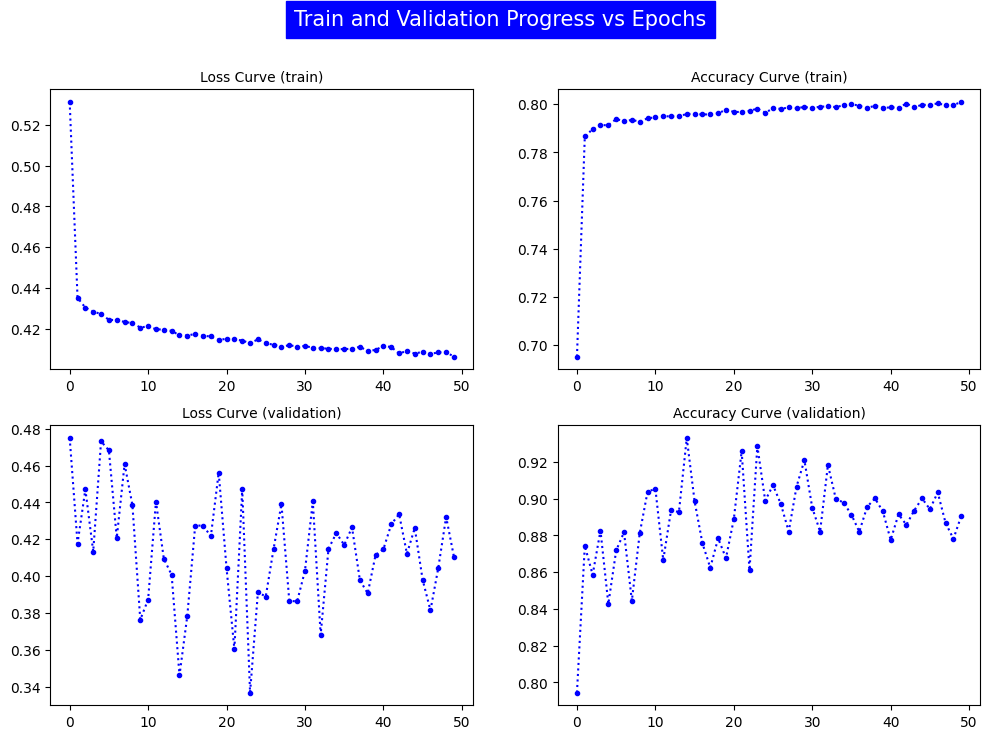

In [12]:
fig, axes = plt.subplots(2, 2,  figsize=(12, 8))

axes[0,0].plot(history.history['loss'], 'b:.')
axes[0,1].plot(history.history['accuracy'], 'b:.')
axes[1,0].plot(history.history['val_loss'], 'b:.')
axes[1,1].plot(history.history['val_accuracy'], 'b:.')

axes[0,0].set_title('Loss Curve (train)', fontsize = 10)
axes[0,1].set_title('Accuracy Curve (train)', fontsize = 10)
axes[1,0].set_title('Loss Curve (validation)', fontsize = 10)
axes[1,1].set_title('Accuracy Curve (validation)', fontsize = 10)
fig.suptitle('Train and Validation Progress vs Epochs', backgroundcolor='blue', color='white', fontsize = 15)
#plt.savefig('figs/Low Stat/Train_Val_progress.png', format = 'png')

## 3.4 - Observation and Analysis of Predictions

### 3.4.1 - NN Prediction

In [13]:
X_sig_pred = model.predict([pixel_sig_test, energy_sig_test, radi_sig_test])
X_bkg_pred = model.predict([pixel_bkg_test, energy_bkg_test, radi_bkg_test])

707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 871us/step
707/707 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step


### 3.4.2 - Analysis of Predictions

In [358]:
X_sig_pred

array([[1.0000000e+00, 0.0000000e+00],
       [4.2886427e-01, 5.7113862e-01],
       [9.9999732e-01, 2.6646915e-06],
       ...,
       [3.2225758e-01, 6.7775404e-01],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [359]:
X_bkg_pred

array([[0.93575513, 0.06423097],
       [0.19464958, 0.8053367 ],
       [0.16686529, 0.8331526 ],
       ...,
       [0.18926041, 0.8107438 ],
       [0.28108582, 0.71892536],
       [0.6491255 , 0.35048512]], dtype=float32)

In [14]:
#Extract mean value of the probability components for each event. Save this info:
vec_prob_sig = []
vec_prob_bkg = []

# Divide arrays of predictions in single event arrays

N = 100 # 100 elements by each event (10x10 images)

nu_events_pred = np.array_split(X_sig_pred, len(X_sig_pred) // (N-1))
bkg_event_pred = np.array_split(X_bkg_pred, len(X_bkg_pred) // (N-1))

N_sig = len(nu_events_pred)
N_bkg = len(bkg_event_pred)

for i_sig, i_bkg in zip(range(N_sig), range(N_bkg)):
    #Extract event predcitions
    nu_ev_pred = nu_events_pred[i_sig]
    bkg_ev_pred = bkg_event_pred[i_bkg]

    #Extract mean value for each component of the probability prediction
    nu_prob_sig, nu_prob_bkg = np.mean(nu_ev_pred[:,0]), np.mean(nu_ev_pred[:,1])
    bkg_prob_sig, bkg_prob_bkg = np.mean(bkg_ev_pred[:,0]), np.mean(bkg_ev_pred[:,1])

    vec_prob_sig.append(np.array([nu_prob_sig, nu_prob_bkg]))
    vec_prob_bkg.append(np.array([bkg_prob_sig, bkg_prob_bkg]))

vec_prob_sig = np.array(vec_prob_sig)
vec_prob_bkg = np.array(vec_prob_bkg)

In [15]:
print('working with ' + str(len(nu_events_pred)) + ' of signal and ' + str(len(bkg_event_pred)) + ' of background as testing data')

working with 228 of signal and 228 of background as testing data


### 3.4.3 - Representation of Predictions

#### Distribution of Probabilities

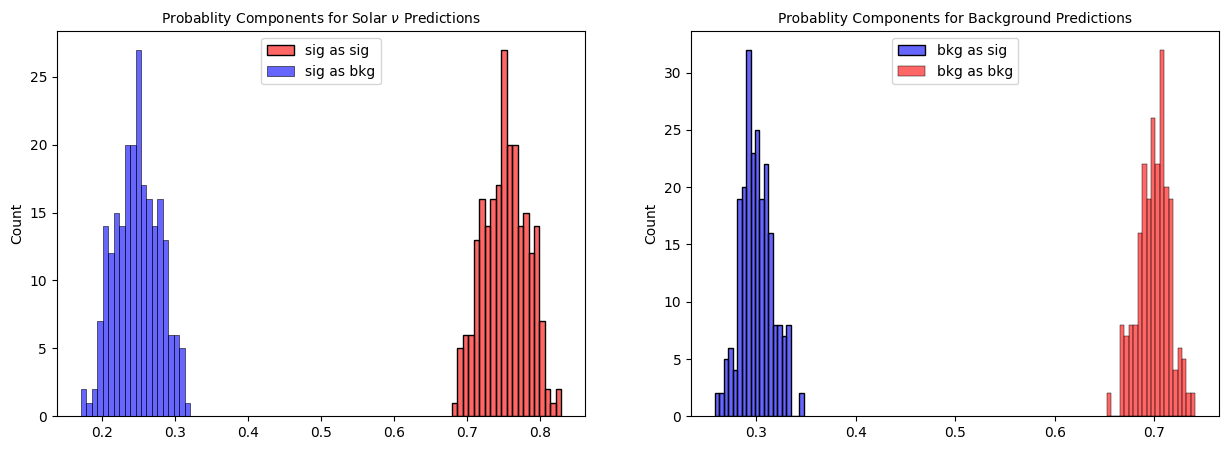

In [23]:
fig, axes = plt.subplots(1, 2,  figsize=(15, 5))

sn.histplot(vec_prob_sig[:,0], bins = 20, label = 'sig as sig', color = 'r', alpha = 0.6, ax = axes[0])
sn.histplot(vec_prob_sig[:,1], bins = 20, label = 'sig as bkg', color = 'b', alpha = 0.6, ax = axes[0])
sn.histplot(vec_prob_bkg[:,0], bins = 20, label = 'bkg as sig',color = 'b', alpha = 0.6, ax = axes[1])
sn.histplot(vec_prob_bkg[:,1], bins = 20, label = 'bkg as bkg', color = 'r', alpha = 0.6, ax = axes[1])
axes[0].set_title('Probablity Components for Solar $ν$ Predictions', fontsize = 10)
axes[1].set_title('Probablity Components for Background Predictions', fontsize = 10)
axes[0].legend(loc = 'upper center')
axes[1].legend(loc = 'upper center')
plt.savefig('figs/Low Stat/probability_predictions.png', format = 'png')